In [2]:
%pip install nbimporter
%pip install scikit-misc

import nbimporter  
import gzip
import shutil
import os
import json 
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectFromModel
from main import generate_predictions
from plotnine import *


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Access SG-NEx data through AWS

In [ ]:
# # list all samples that have processed data for RNA modification detection using m6Anet
!aws s3 ls --no-sign-request s3://sg-nex-data/data/processed_data/m6Anet/  

# saves all samples that have processed data for RNA modification detection using m6Anet under data directory
!aws s3 cp --no-sign-request s3://sg-nex-data/data/processed_data/m6Anet/ ../data/sg-nex-data/raw/

## Prediction of SG-NEx data using Random Forest

In [ ]:
def generate_prediction_files(raw_directory, prediction_directory):
    
    '''
    Generates csv files containing prediction scores from raw SG-Nex data json files. Also appends important features to the csv files.
    Uses generate_predictions() function from main.ipynb to write prediction to prediction_directory.
    
    Parameter:
    - raw_directory: Directory that stores raw SG-Nex data json files
    - prediction_directory: Directory to store newly generated prediction csv files.
    '''
    
    # Ensure the output directory exists
    os.makedirs(prediction_directory, exist_ok=True)

    # Iterate through each folder in the data directory
    for root, dirs, files in os.walk(raw_directory):
        for file in files:
            if file.endswith('.json'):
                input_path = os.path.join(root, file)
                
                # Get the base folder name from the input path
                folder_name = os.path.basename(root)
                
                # Construct the output path
                output_path = os.path.join(prediction_directory, f"{folder_name}.csv")
                
                print(f"Processing: {input_path}")
                print(f"Output will be saved to: {output_path}")
                
                # Call prediction function
                generate_predictions(input_path, '../model/selector.joblib.gz', '../model/rf_classifier.joblib.gz', output_path, include_features = True)

                # Remove the folder after the CSV is successfully exported
                shutil.rmtree(root)
                print(f"Removed folder: {root}")

    # Remove sg-nex-data directory 
    sgnex_directory = os.path.dirname(raw_directory)  
    shutil.rmtree(sgnex_directory)  # This will remove 'data/' and everything inside it
    print(f"Removed sg-nex-data directory: {sgnex_directory}")

raw_directory = '../data/sg-nex-data/raw'
prediction_directory = '../output'
generate_prediction_files(raw_directory, prediction_directory)


In [6]:
'''
Iterates through all prediction files in prediction_directory and loads csv files into their corresponding cell_line dataframe.
All individual cell_line dataframes are concatenated to form dataframe combined_data.
'''

# Directory containing the prediction CSV files
prediction_directory = '../output'

# Dictionary to store dataframes by cell line
cell_line_dataframes = {
    'A549': [],
    'Hct116': [],
    'K562': [],
    'HepG2': [],
    'MCF7': []
}

# Iterate through the files in the prediction directory
for file_name in os.listdir(prediction_directory):
    if file_name.endswith('.csv'):
        file_path = os.path.join(prediction_directory, file_name)
        
        # Load the CSV file into a dataframe
        df = pd.read_csv(file_path)
        
        # Check the file name to determine which cell line it belongs to
        if 'A549' in file_name:
            df['cell_line'] = 'A549'
            cell_line_dataframes['A549'].append(df)
        elif 'Hct116' in file_name:
            df['cell_line'] = 'Hct116'
            cell_line_dataframes['Hct116'].append(df)
        elif 'K562' in file_name:
            df['cell_line'] = 'K562'
            cell_line_dataframes['K562'].append(df)
        elif 'HepG2' in file_name:
            df['cell_line'] = 'HepG2'
            cell_line_dataframes['HepG2'].append(df)
        elif 'MCF7' in file_name:
            df['cell_line'] = 'MCF7'
            cell_line_dataframes['MCF7'].append(df)

# Concatenate dataframes for each cell line into a single dataframe
combined_data = pd.concat(
    [pd.concat(dfs) for dfs in cell_line_dataframes.values() if dfs], 
    ignore_index=True
)


## Visualisations

In [7]:
'''
Further processing performed on dataframe for visualisations
'''

# Add additional column to categorize Modification based on score
combined_data['Modification'] = 'Unmodified'
combined_data.loc[combined_data['score'] > 0.9, 'Modification'] = 'Modified'

# Filter the data for scores > 0.9
filtered_data = combined_data[combined_data['score'] > 0.9]

### Line graph to show Dwelling Time and Mean Current Ranges by Relative Position (-1, 0, +1)

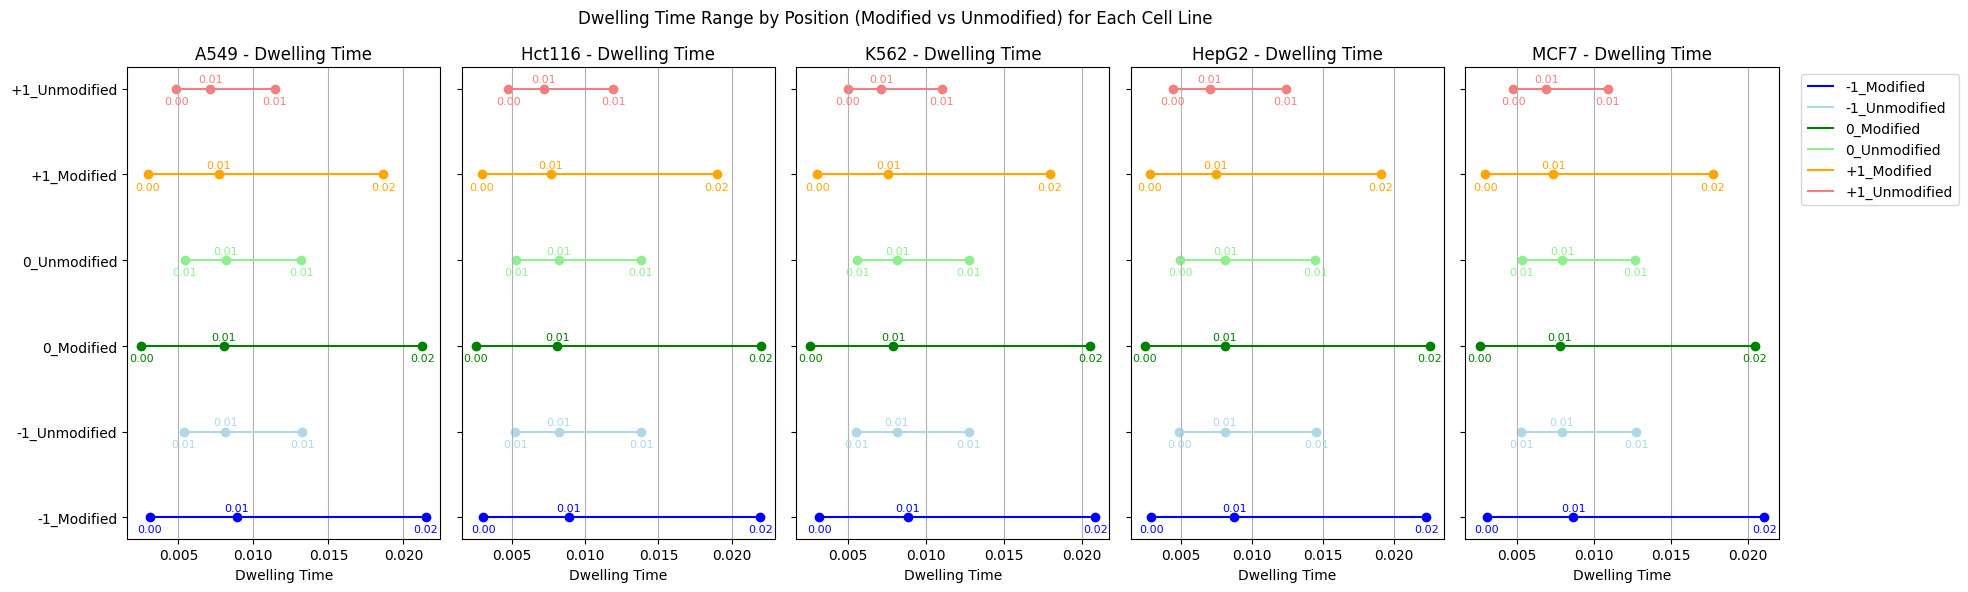

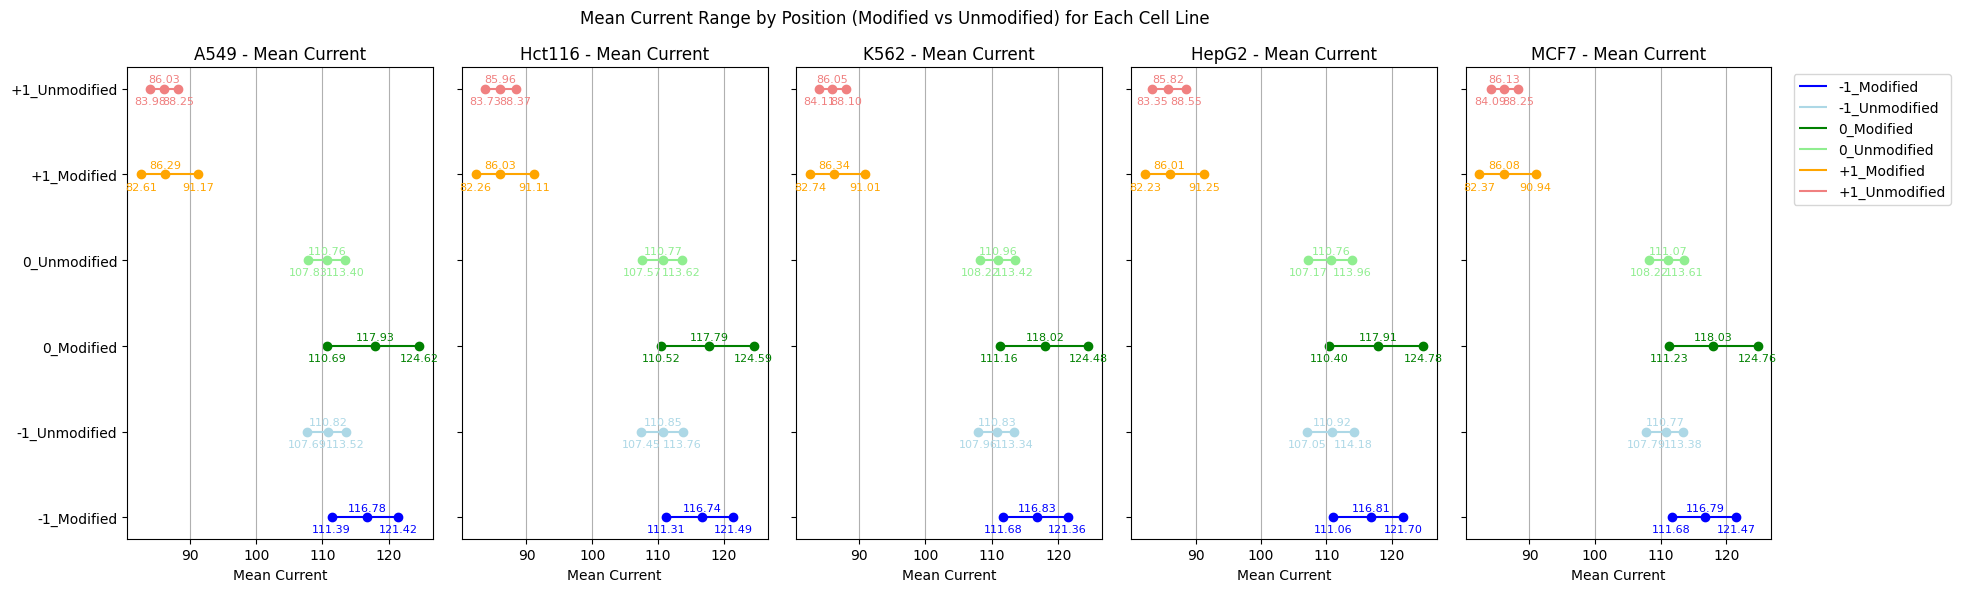

In [8]:
# Calculate means for each category and position for dwelling time and mean current
cell_lines = combined_data['cell_line'].unique()
dwelling_time_means = {}
mean_current_means = {}

for cell_line in cell_lines:
    dwelling_time_means[cell_line] = {
        '-1_Modified': [
            combined_data.loc[(combined_data['Modification'] == 'Modified') & (combined_data['cell_line'] == cell_line), '-1_dwelling_time_min'].mean(),
            combined_data.loc[(combined_data['Modification'] == 'Modified') & (combined_data['cell_line'] == cell_line), '-1_dwelling_time_mean'].mean(),
            combined_data.loc[(combined_data['Modification'] == 'Modified') & (combined_data['cell_line'] == cell_line), '-1_dwelling_time_max'].mean()
        ],
        '-1_Unmodified': [
            combined_data.loc[(combined_data['Modification'] == 'Unmodified') & (combined_data['cell_line'] == cell_line), '-1_dwelling_time_min'].mean(),
            combined_data.loc[(combined_data['Modification'] == 'Unmodified') & (combined_data['cell_line'] == cell_line), '-1_dwelling_time_mean'].mean(),
            combined_data.loc[(combined_data['Modification'] == 'Unmodified') & (combined_data['cell_line'] == cell_line), '-1_dwelling_time_max'].mean()
        ],
        '0_Modified': [
            combined_data.loc[(combined_data['Modification'] == 'Modified') & (combined_data['cell_line'] == cell_line), '0_dwelling_time_min'].mean(),
            combined_data.loc[(combined_data['Modification'] == 'Modified') & (combined_data['cell_line'] == cell_line), '0_dwelling_time_mean'].mean(),
            combined_data.loc[(combined_data['Modification'] == 'Modified') & (combined_data['cell_line'] == cell_line), '0_dwelling_time_max'].mean()
        ],
        '0_Unmodified': [
            combined_data.loc[(combined_data['Modification'] == 'Unmodified') & (combined_data['cell_line'] == cell_line), '0_dwelling_time_min'].mean(),
            combined_data.loc[(combined_data['Modification'] == 'Unmodified') & (combined_data['cell_line'] == cell_line), '0_dwelling_time_mean'].mean(),
            combined_data.loc[(combined_data['Modification'] == 'Unmodified') & (combined_data['cell_line'] == cell_line), '0_dwelling_time_max'].mean()
        ],
        '+1_Modified': [
            combined_data.loc[(combined_data['Modification'] == 'Modified') & (combined_data['cell_line'] == cell_line), '+1_dwelling_time_min'].mean(),
            combined_data.loc[(combined_data['Modification'] == 'Modified') & (combined_data['cell_line'] == cell_line), '+1_dwelling_time_mean'].mean(),
            combined_data.loc[(combined_data['Modification'] == 'Modified') & (combined_data['cell_line'] == cell_line), '+1_dwelling_time_max'].mean()
        ],
        '+1_Unmodified': [
            combined_data.loc[(combined_data['Modification'] == 'Unmodified') & (combined_data['cell_line'] == cell_line), '+1_dwelling_time_min'].mean(),
            combined_data.loc[(combined_data['Modification'] == 'Unmodified') & (combined_data['cell_line'] == cell_line), '+1_dwelling_time_mean'].mean(),
            combined_data.loc[(combined_data['Modification'] == 'Unmodified') & (combined_data['cell_line'] == cell_line), '+1_dwelling_time_max'].mean()
        ]
    }

    mean_current_means[cell_line] = {
        '-1_Modified': [
            combined_data.loc[(combined_data['Modification'] == 'Modified') & (combined_data['cell_line'] == cell_line), '-1_mean_current_min'].mean(),
            combined_data.loc[(combined_data['Modification'] == 'Modified') & (combined_data['cell_line'] == cell_line), '-1_mean_current_mean'].mean(),
            combined_data.loc[(combined_data['Modification'] == 'Modified') & (combined_data['cell_line'] == cell_line), '-1_mean_current_max'].mean()
        ],
        '-1_Unmodified': [
            combined_data.loc[(combined_data['Modification'] == 'Unmodified') & (combined_data['cell_line'] == cell_line), '-1_mean_current_min'].mean(),
            combined_data.loc[(combined_data['Modification'] == 'Unmodified') & (combined_data['cell_line'] == cell_line), '-1_mean_current_mean'].mean(),
            combined_data.loc[(combined_data['Modification'] == 'Unmodified') & (combined_data['cell_line'] == cell_line), '-1_mean_current_max'].mean()
        ],
        '0_Modified': [
            combined_data.loc[(combined_data['Modification'] == 'Modified') & (combined_data['cell_line'] == cell_line), '0_mean_current_min'].mean(),
            combined_data.loc[(combined_data['Modification'] == 'Modified') & (combined_data['cell_line'] == cell_line), '0_mean_current_mean'].mean(),
            combined_data.loc[(combined_data['Modification'] == 'Modified') & (combined_data['cell_line'] == cell_line), '0_mean_current_max'].mean()
        ],
        '0_Unmodified': [
            combined_data.loc[(combined_data['Modification'] == 'Unmodified') & (combined_data['cell_line'] == cell_line), '0_mean_current_min'].mean(),
            combined_data.loc[(combined_data['Modification'] == 'Unmodified') & (combined_data['cell_line'] == cell_line), '0_mean_current_mean'].mean(),
            combined_data.loc[(combined_data['Modification'] == 'Unmodified') & (combined_data['cell_line'] == cell_line), '0_mean_current_max'].mean()
        ],
        '+1_Modified': [
            combined_data.loc[(combined_data['Modification'] == 'Modified') & (combined_data['cell_line'] == cell_line), '+1_mean_current_min'].mean(),
            combined_data.loc[(combined_data['Modification'] == 'Modified') & (combined_data['cell_line'] == cell_line), '+1_mean_current_mean'].mean(),
            combined_data.loc[(combined_data['Modification'] == 'Modified') & (combined_data['cell_line'] == cell_line), '+1_mean_current_max'].mean()
        ],
        '+1_Unmodified': [
            combined_data.loc[(combined_data['Modification'] == 'Unmodified') & (combined_data['cell_line'] == cell_line), '+1_mean_current_min'].mean(),
            combined_data.loc[(combined_data['Modification'] == 'Unmodified') & (combined_data['cell_line'] == cell_line), '+1_mean_current_mean'].mean(),
            combined_data.loc[(combined_data['Modification'] == 'Unmodified') & (combined_data['cell_line'] == cell_line), '+1_mean_current_max'].mean()
        ]
    }

# Define colors for each category
colors = {
    '-1_Modified': 'blue',
    '-1_Unmodified': 'lightblue',
    '0_Modified': 'green',
    '0_Unmodified': 'lightgreen',
    '+1_Modified': 'orange',
    '+1_Unmodified': 'lightcoral'
}

# Define the order of positions for plotting
ordered_labels = ['-1_Modified', '-1_Unmodified', '0_Modified', '0_Unmodified', '+1_Modified', '+1_Unmodified']
positions = list(range(len(ordered_labels)))  # Numeric positions for y-axis

# Function to add labels above points with vertical offset
def add_value_labels(ax, values, y_position, color):
    for idx, val in enumerate(values):
        # Adjust label position to prevent overlap
        vertical_offset = 0.05 if idx == 1 else -0.2 
        
        ax.text( 
            val, 
            y_position + vertical_offset, 
            f'{val:.2f}', 
            va='bottom', 
            ha='center', 
            color=color, 
            fontsize=8
        )

# Dwelling time plots with FacetGrid for each cell line
fig, axes = plt.subplots(nrows=1, ncols=len(cell_lines), figsize=(18, 6), sharey=True)
for i, cell_line in enumerate(cell_lines):
    ax = axes[i]
    for label in ordered_labels:
        color = colors[label]
        values = dwelling_time_means[cell_line][label]
        y_position = positions[ordered_labels.index(label)]
        
        # Plot line and points
        ax.hlines(y=y_position, xmin=values[0], xmax=values[2], colors=color, label=label)
        ax.scatter(values, [y_position] * 3, color=color)
        
        # Add value labels above the points
        add_value_labels(ax, values, y_position, color)
    
    ax.set_yticks(positions)
    ax.set_yticklabels(ordered_labels)
    ax.set_title(f'{cell_line} - Dwelling Time')
    ax.set_xlabel('Dwelling Time')
    ax.grid(axis='x')

plt.suptitle('Dwelling Time Range by Position (Modified vs Unmodified) for Each Cell Line')
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



# Mean current plots with FacetGrid for each cell line
fig, axes = plt.subplots(nrows=1, ncols=len(cell_lines), figsize=(18, 6), sharey=True)
for i, cell_line in enumerate(cell_lines):
    ax = axes[i]
    for label in ordered_labels:
        color = colors[label]
        values = mean_current_means[cell_line][label]
        y_position = positions[ordered_labels.index(label)]
        
        # Plot line and points
        ax.hlines(y=y_position, xmin=values[0], xmax=values[2], colors=color, label=label)
        ax.scatter(values, [y_position] * 3, color=color)
        
        # Add value labels above the points
        add_value_labels(ax, values, y_position, color)
    
    ax.set_yticks(positions)
    ax.set_yticklabels(ordered_labels)
    ax.set_title(f'{cell_line} - Mean Current')
    ax.set_xlabel('Mean Current')
    ax.grid(axis='x')

plt.suptitle('Mean Current Range by Position (Modified vs Unmodified) for Each Cell Line')
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


### Box plot to analyse standard deviation

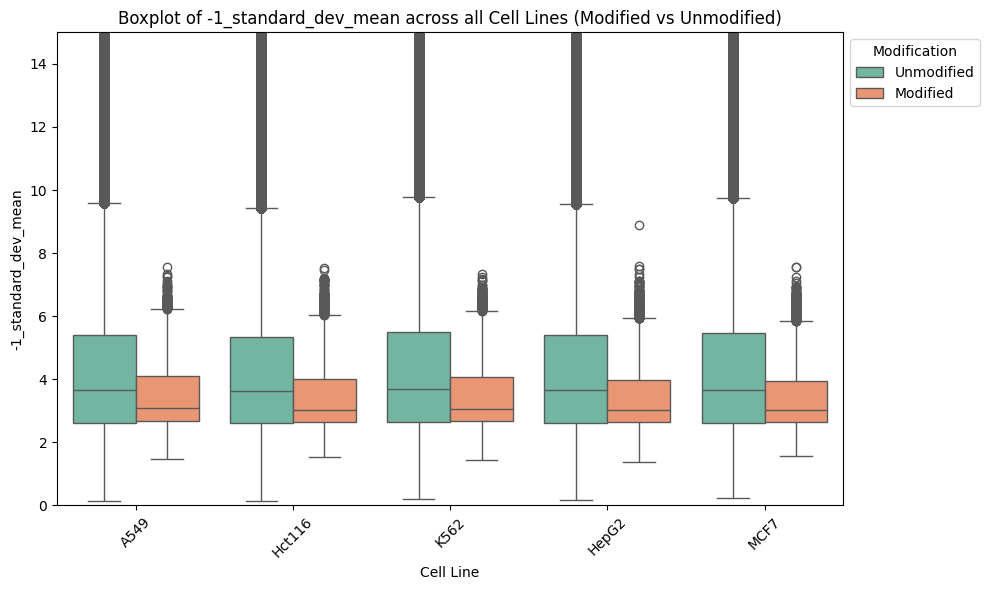

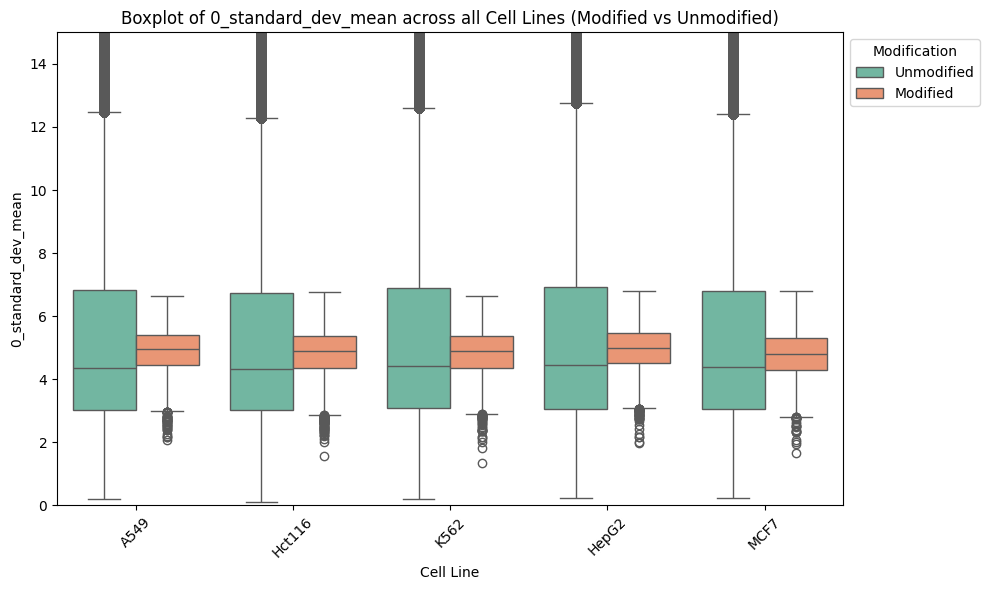

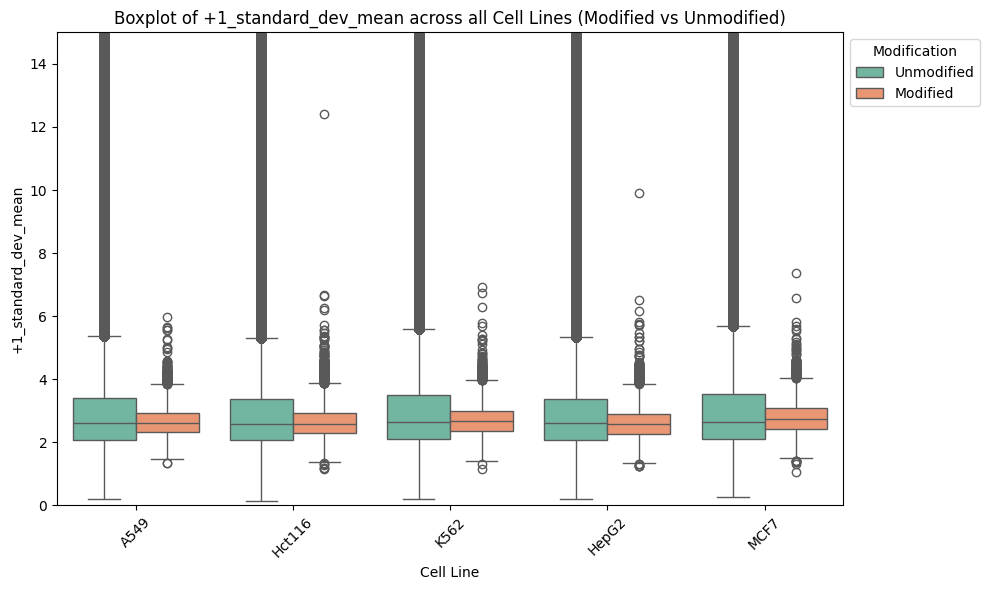

In [9]:
# Define features to plot along with their corresponding y-limits
features = [
    '-1_standard_dev_mean',
    '0_standard_dev_mean',
    '+1_standard_dev_mean'
]

y_limits = {
    '-1_standard_dev_mean': (0, 15),
    '0_standard_dev_mean': (0, 15),
    '+1_standard_dev_mean': (0, 15)
}

# Loop through each feature to create individual plots
for feature in features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        data=combined_data,
        x='cell_line',
        y=feature,
        hue='Modification',
        palette='Set2'
    )
    
    plt.title(f'Boxplot of {feature} across all Cell Lines (Modified vs Unmodified)')
    plt.xlabel('Cell Line')
    plt.ylabel(feature)
    plt.ylim(y_limits[feature])  # Set the y-limit for each feature
    plt.legend(title='Modification', loc='upper left', bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### Density Plot to analyse Distribution of Transcript Positions

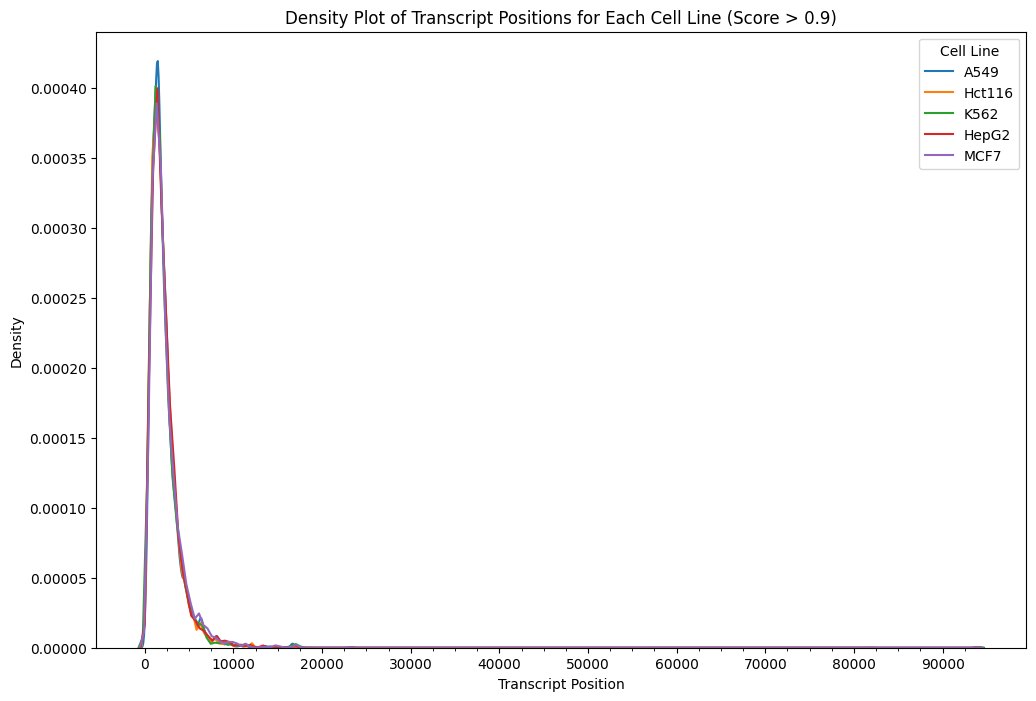

In [10]:
# Filter the data for scores > 0.9
filtered_data = combined_data[combined_data['score'] > 0.9]

# Set up the plot
plt.figure(figsize=(12, 8))

# Loop through each cell line and plot the density
for cell_line in filtered_data['cell_line'].unique():
    sns.kdeplot(
        data=filtered_data[filtered_data['cell_line'] == cell_line], 
        x='transcript_position', 
        label=cell_line, 
        fill=False, 
        bw_adjust=0.5 
    )

# Adding labels and title
plt.xlabel('Transcript Position')
plt.ylabel('Density')
plt.title('Density Plot of Transcript Positions for Each Cell Line (Score > 0.9)')
plt.legend(title='Cell Line')

# Set x-axis ticks and labels
x_ticks = np.arange(0, filtered_data['transcript_position'].max(), 10000)
plt.xticks(ticks=x_ticks, labels=x_ticks)

# Add minor ticks at intervals of 2500
plt.gca().set_xticks(np.arange(0, filtered_data['transcript_position'].max(), 2500), minor=True)

# Show the plot
plt.show()


### Line Graph to show Range of Modified Transcript Positions

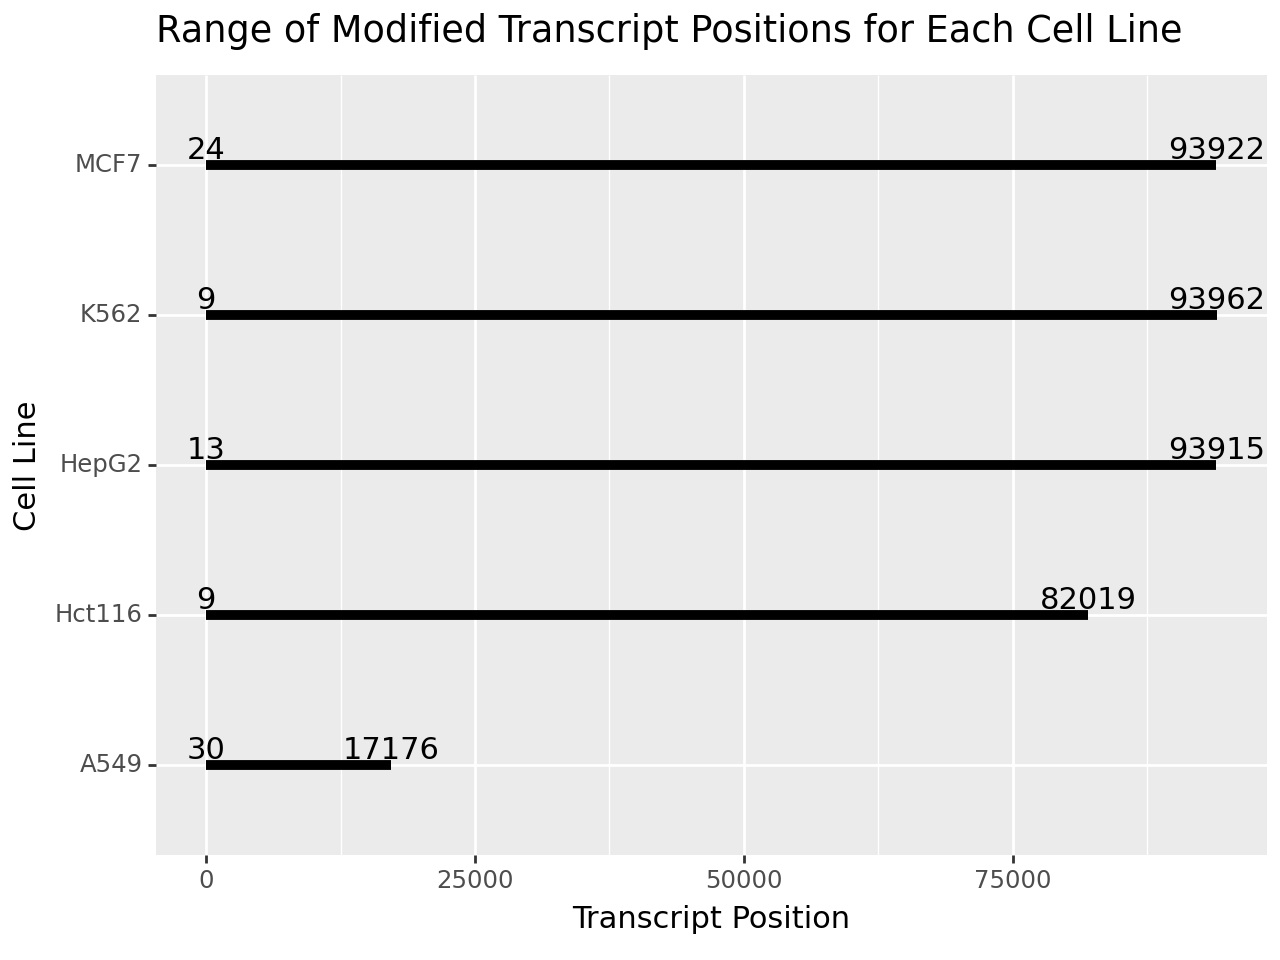

In [12]:
# Calculate the min and max transcript positions for each cell line
range_data = filtered_data.groupby('cell_line').agg(
    min_position=('transcript_position', 'min'),
    max_position=('transcript_position', 'max')
).reset_index()

# Create plot
plot = (
    ggplot(range_data, aes(x='min_position', y='cell_line'))  # Min position on x-axis, cell line on y-axis
    + geom_segment(aes(x='min_position', xend='max_position', y='cell_line', yend='cell_line'), size=2)
    + geom_text(aes(x='min_position', label='min_position'), 
                nudge_x=-1, color='black', va='bottom')  # Label min values
    + geom_text(aes(x='max_position', label='max_position'), 
                nudge_x=1, color='black', va='bottom')  # Label max values
    + labs(
        title='Range of Modified Transcript Positions for Each Cell Line',
        x='Transcript Position',
        y='Cell Line'
    )
)

print(plot)


### Scatterplot to analyse Score by Transcript Positions

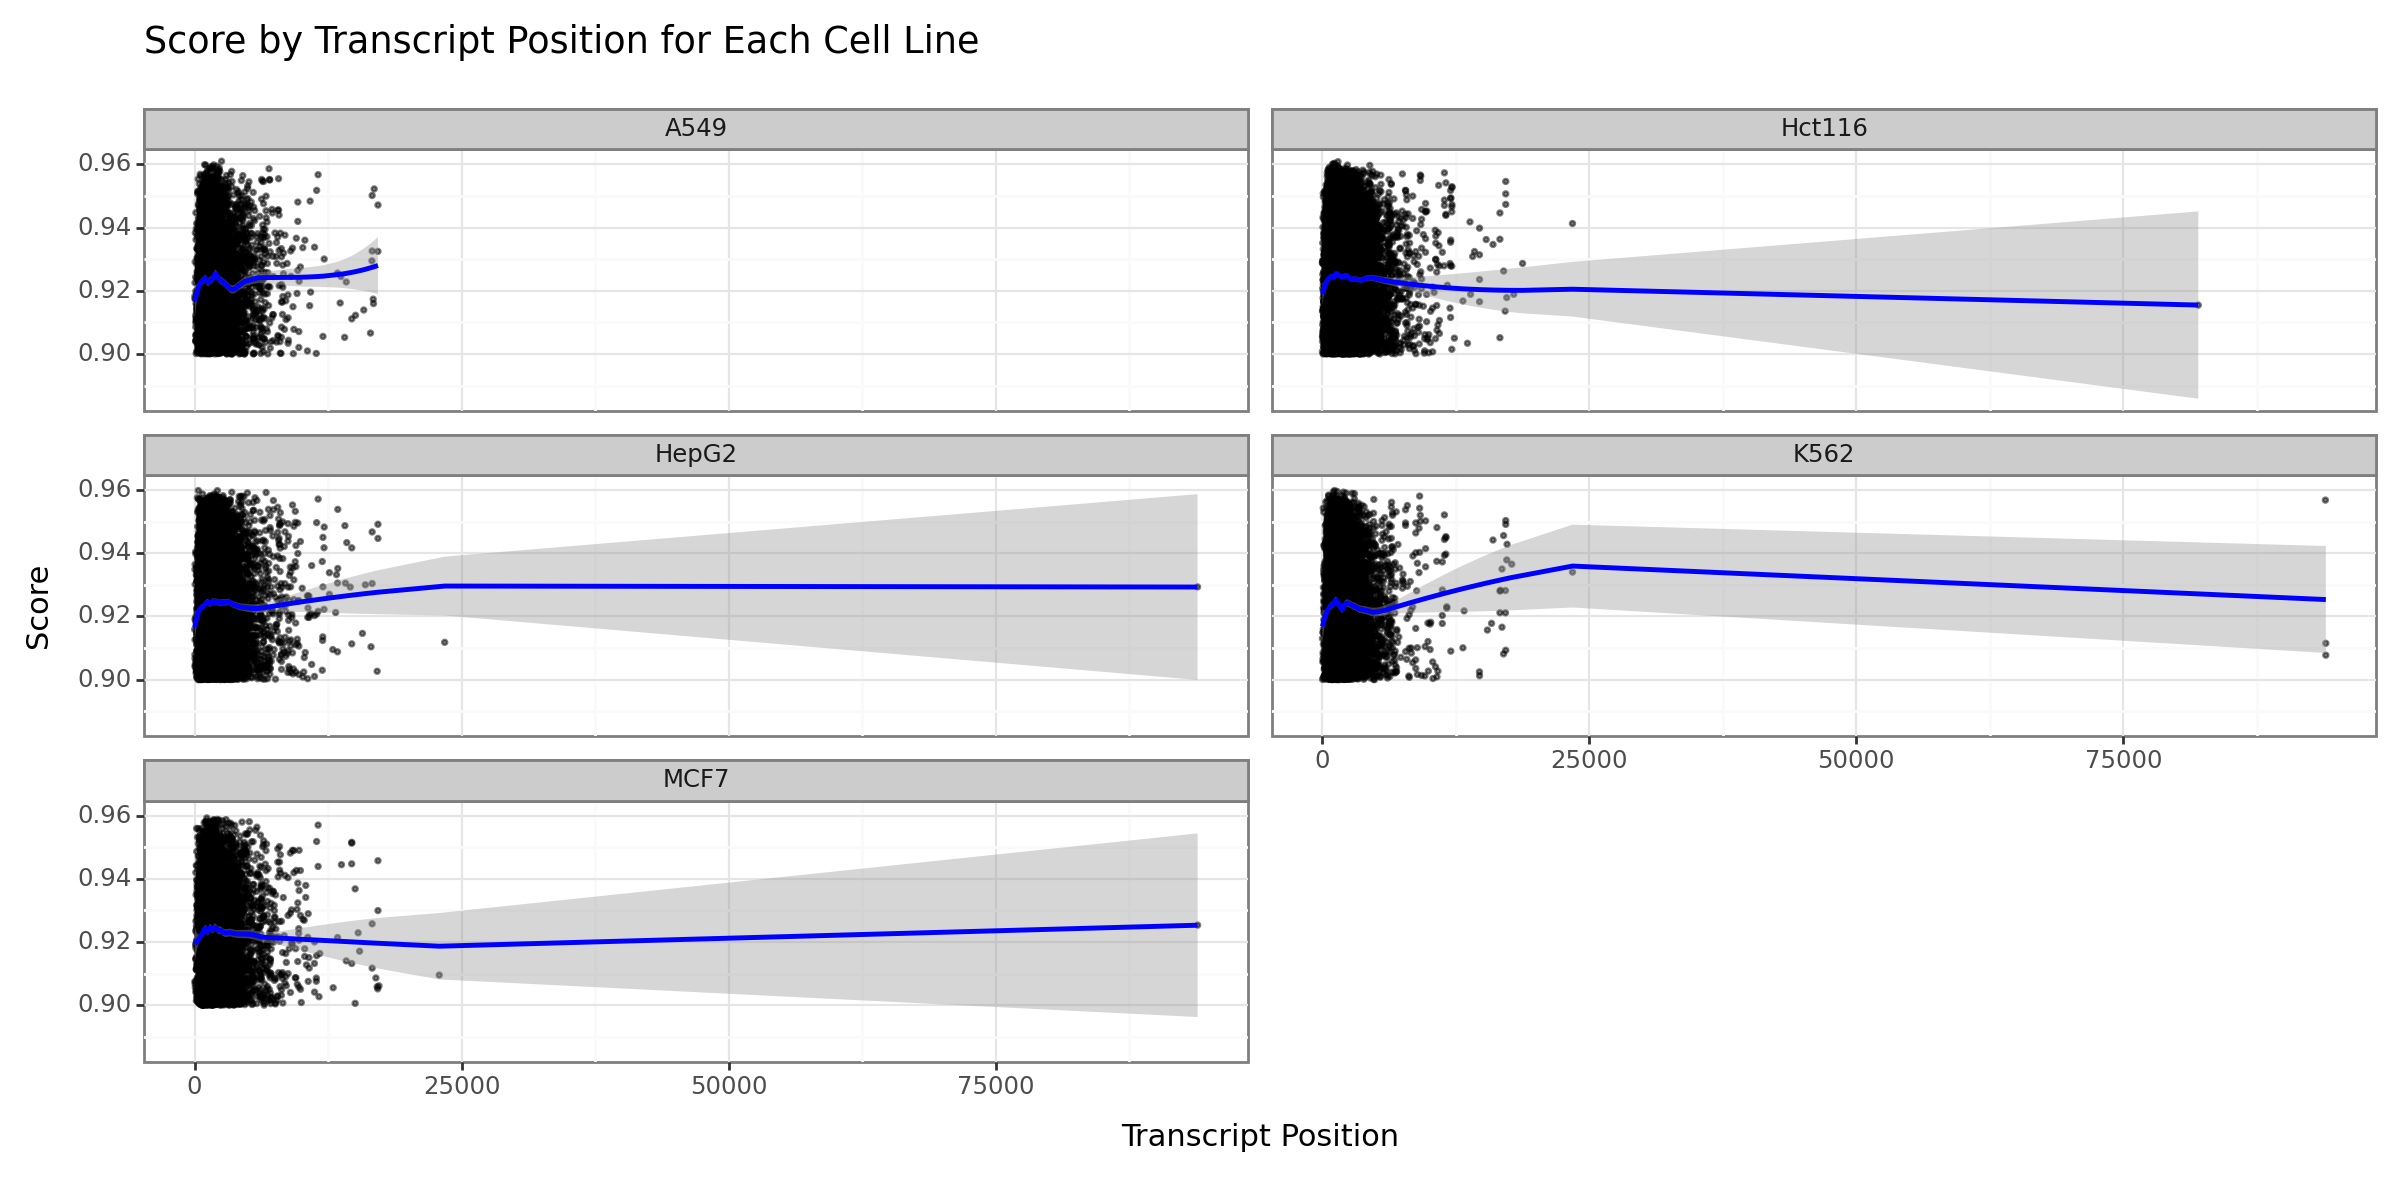

In [13]:
# Set up the plot with FacetGrid
plot = (
    ggplot(filtered_data, aes(x='transcript_position', y='score'))
    + geom_point(size=0.5, alpha=0.5)
    + geom_smooth(method='loess', color='blue', span=0.3, se=True)  # Adjust span as needed
    + labs(
        title='Score by Transcript Position for Each Cell Line',
        x='Transcript Position',
        y='Score'
    )
    + facet_wrap('~ cell_line', ncol=2)  # Adjust ncol as needed for layout
    + theme_bw()
    + theme(figure_size=(12, 6))
)

print(plot)


### LOESS Lines overlay for all Cell Lines

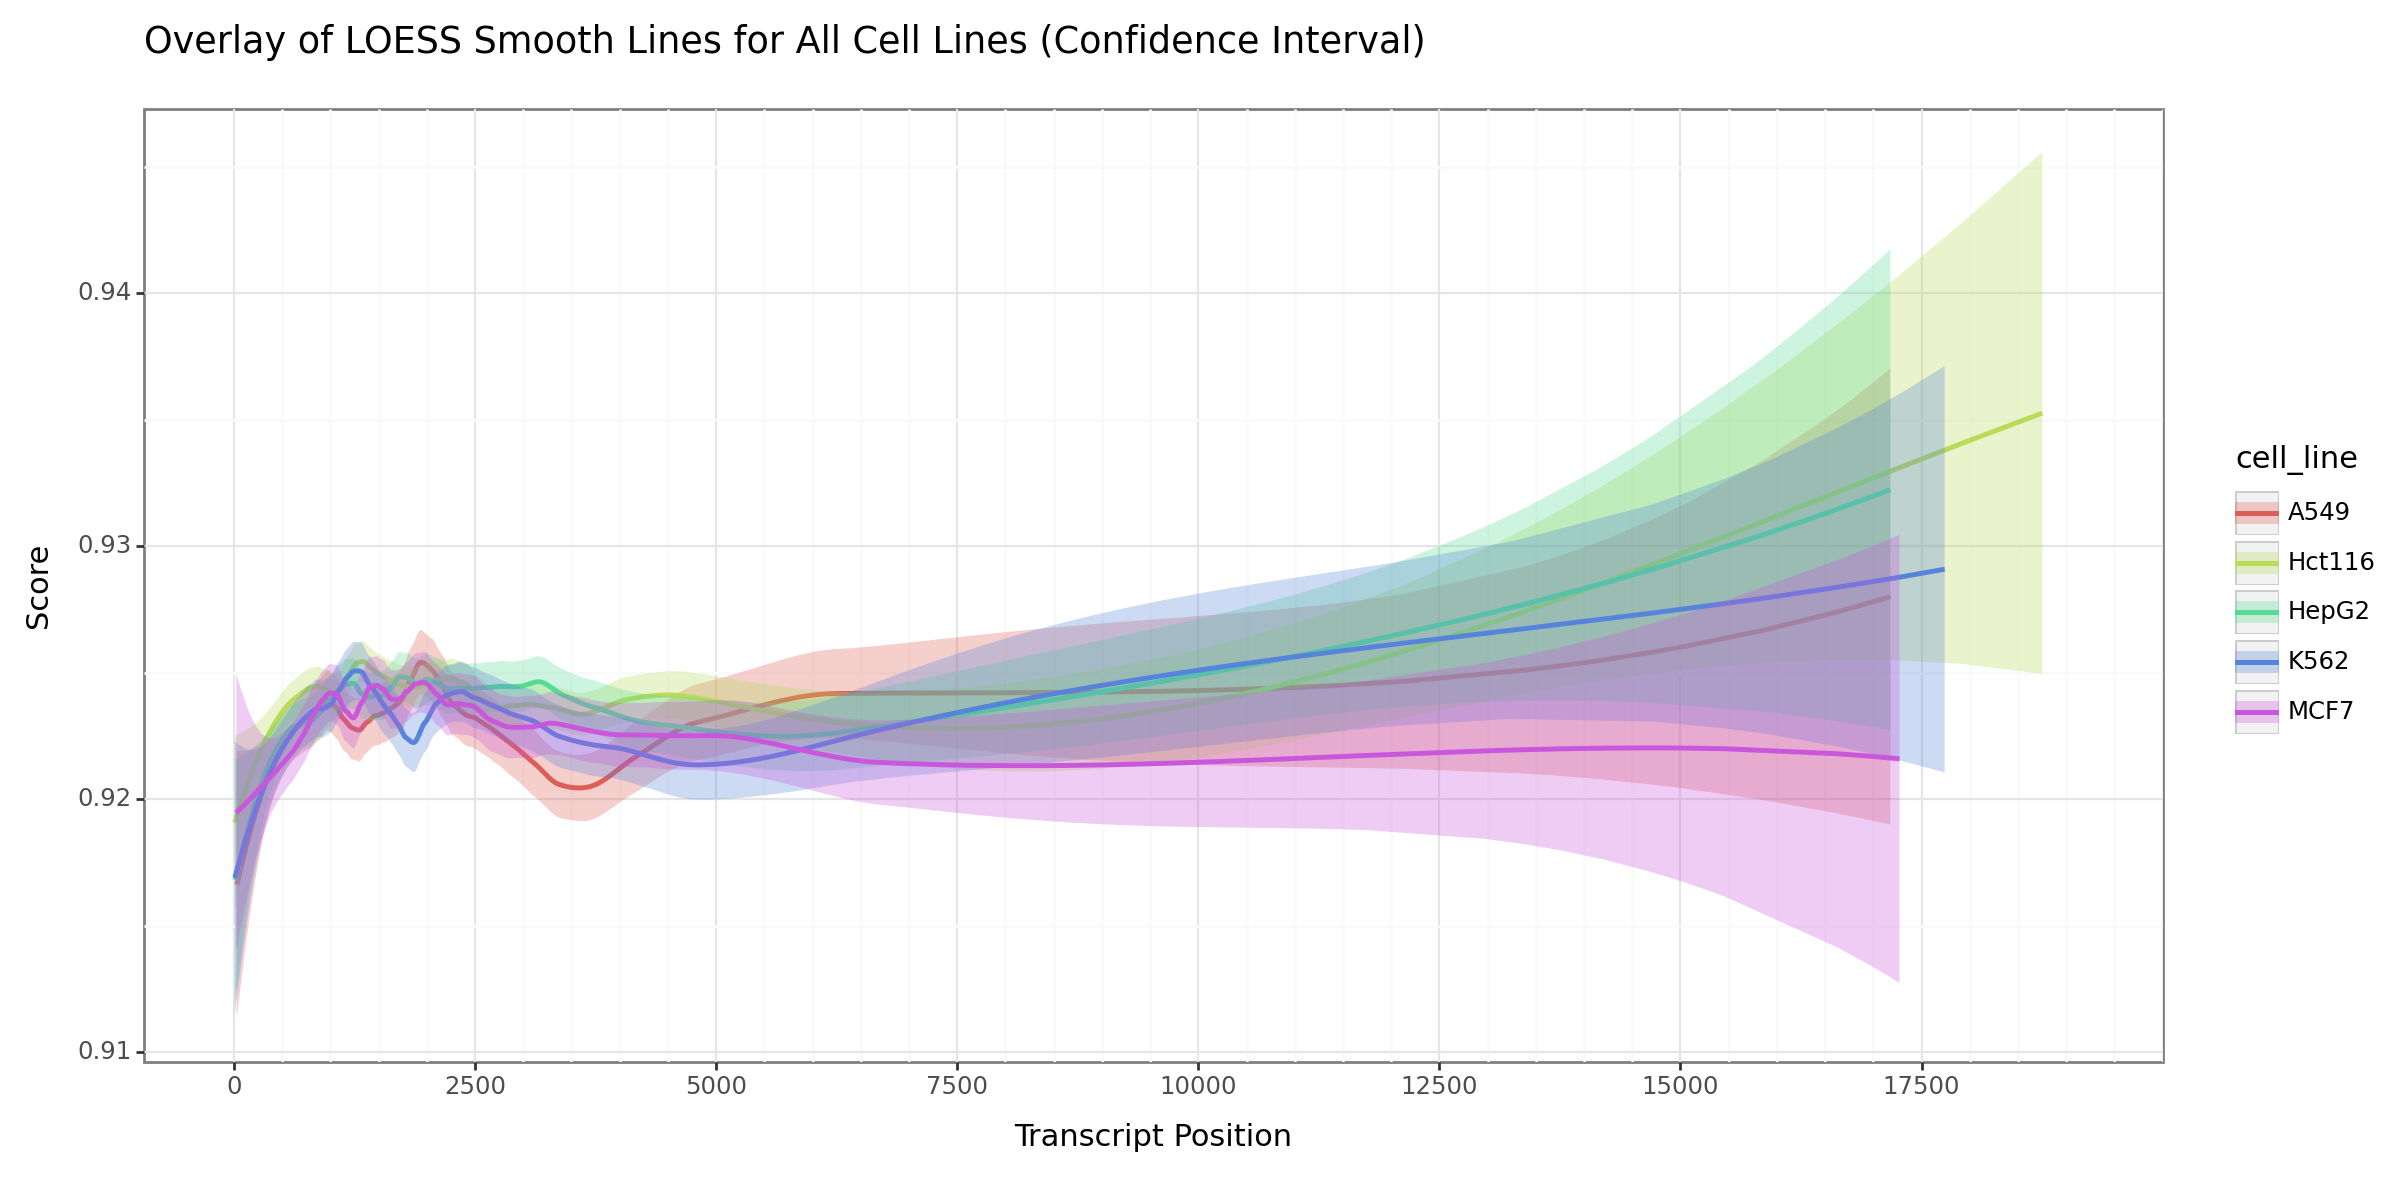

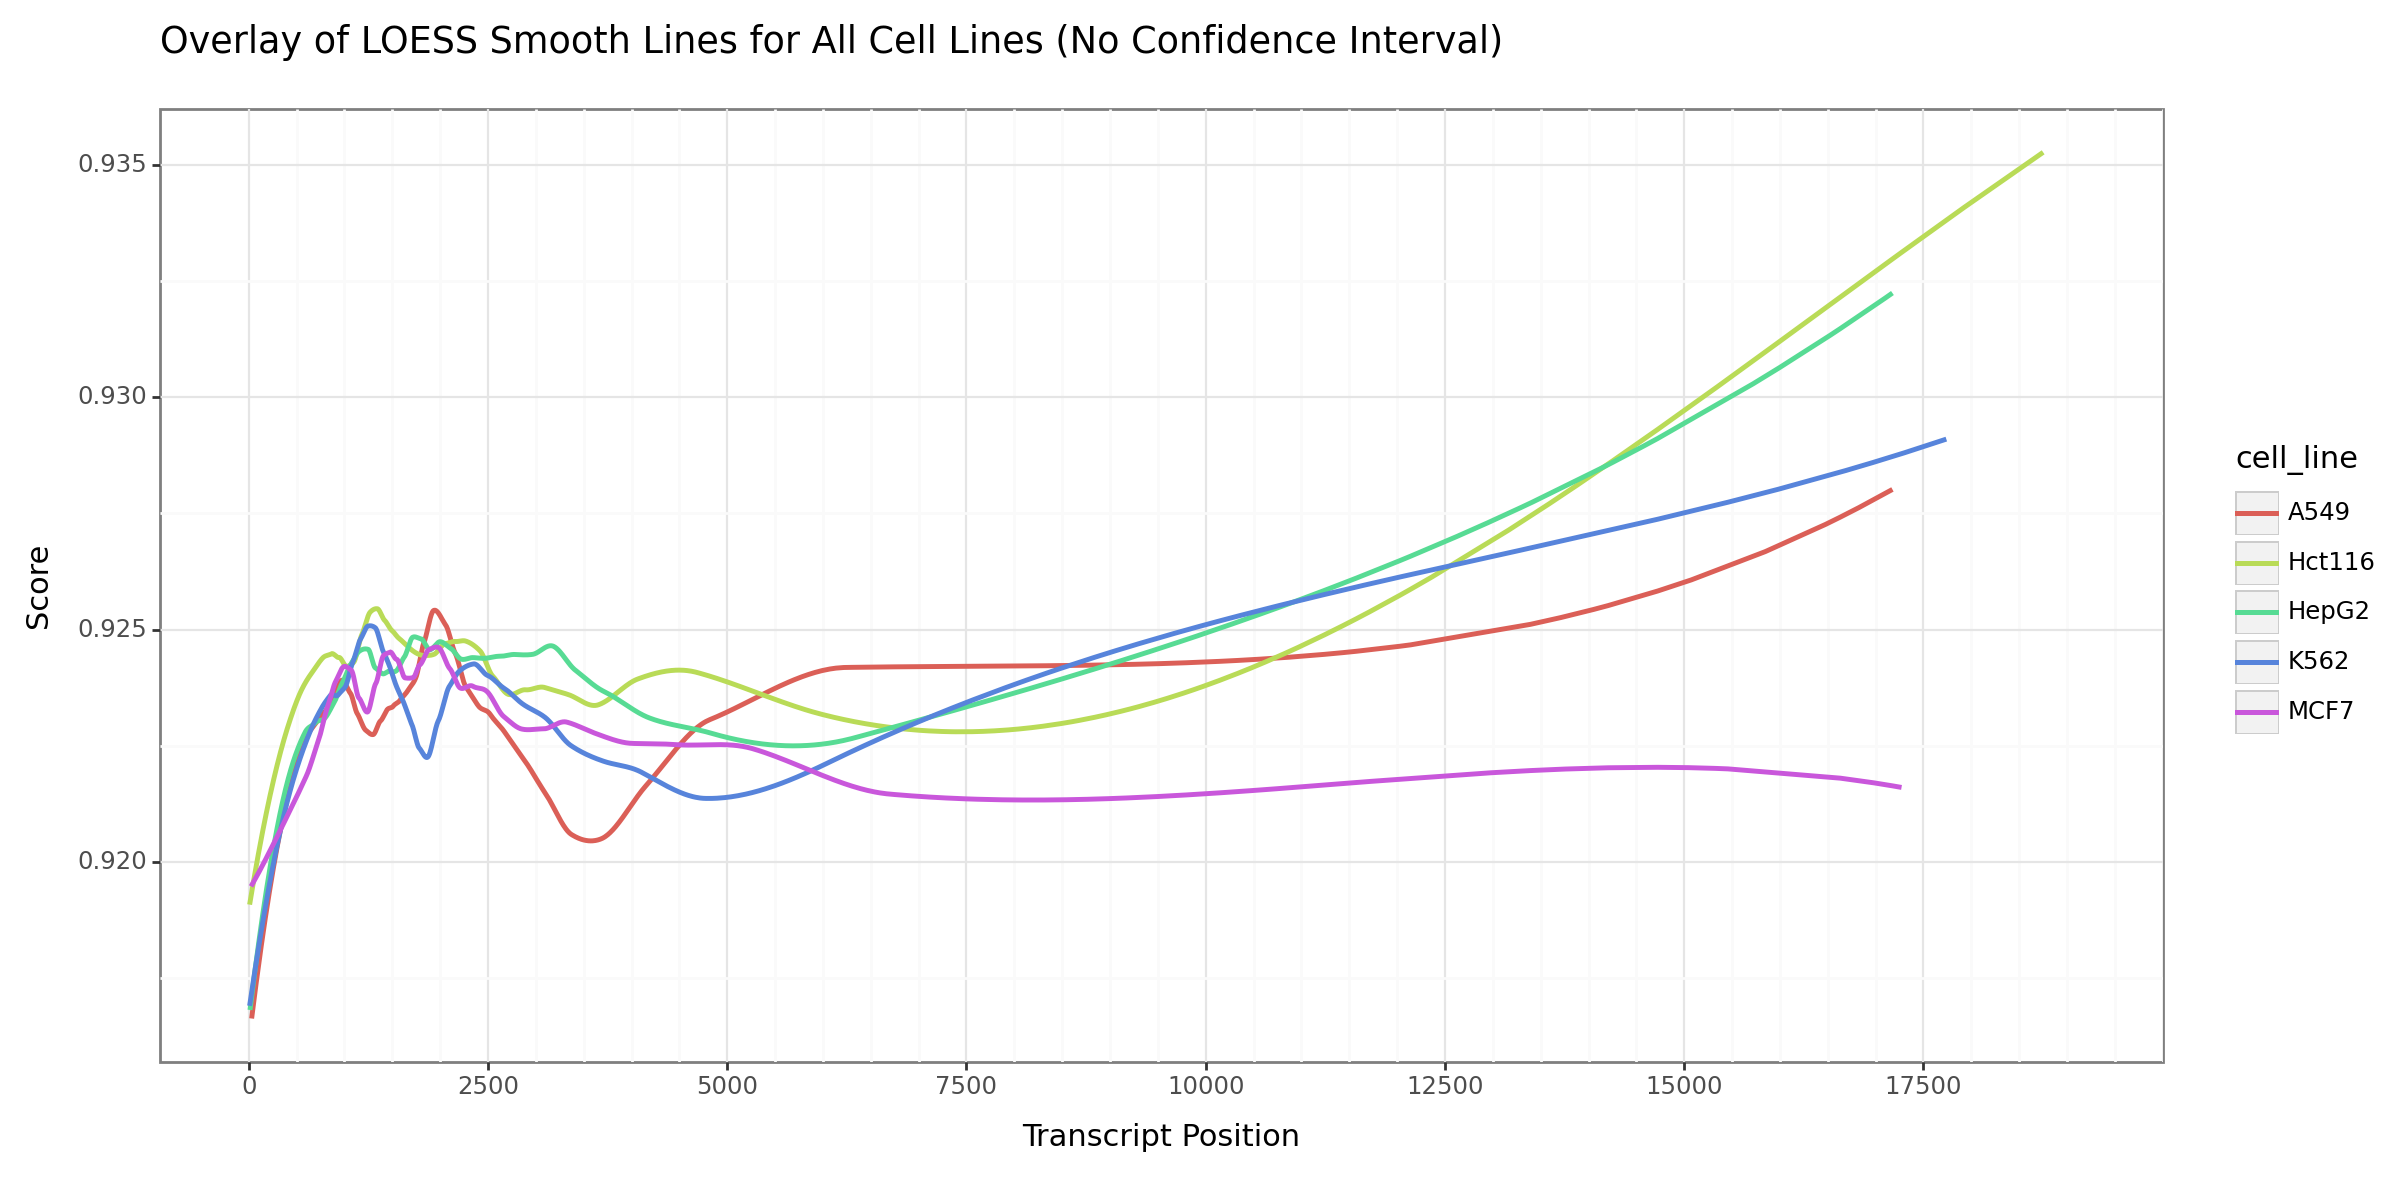

In [14]:
# Filter the data for transcript positions < 20000
filtered_data_overlay = filtered_data[filtered_data['transcript_position'] < 20000]

# Create a combined plot for all cell lines with LOESS smooth lines (with confidence interval)
overlay_plot_1 = (
    ggplot(filtered_data_overlay, aes(x='transcript_position', y='score', color='cell_line', fill='cell_line', group='cell_line'))
    + geom_smooth(method='loess', span=0.3, se=True, alpha=0.3)
    + labs(
        title='Overlay of LOESS Smooth Lines for All Cell Lines (Confidence Interval)',
        x='Transcript Position',
        y='Score'
    )
    + scale_x_continuous(breaks=range(0, 20001, 2500), minor_breaks=range(0, 20001, 500))  # Major ticks every 2500, minor ticks every 500
    + theme_bw()
    + theme(figure_size=(12, 6))
)

print(overlay_plot_1)

# Create a combined plot for all cell lines with LOESS smooth lines (without confidence interval)
overlay_plot_2 = (
    ggplot(filtered_data_overlay, aes(x='transcript_position', y='score', color='cell_line', fill='cell_line', group='cell_line'))
    + geom_smooth(method='loess', span=0.3, se=False, alpha=0.3)
    + labs(
        title='Overlay of LOESS Smooth Lines for All Cell Lines (No Confidence Interval)',
        x='Transcript Position',
        y='Score'
    )
    + scale_x_continuous(breaks=range(0, 20001, 2500), minor_breaks=range(0, 20001, 500))  # Major ticks every 2500, minor ticks every 500
    + theme_bw()
    + theme(figure_size=(12, 6))
)

print(overlay_plot_2)
